In [1]:
from dynesty import NestedSampler
import numpy as np
import pickle


In [2]:
path = "8/model1/Lens/"

with open(path+f'phase5/Final_sampler_phase5.pickle','rb') as f:
    sampler = pickle.load(f)
    f.close()

with open(path+f'phase5/phase5.pickle','rb') as f:
    ph5 = pickle.load(f)
    f.close()

with open(path+f'phase5/log_likelihood_phase5.pickle','rb') as f:
    log_like = pickle.load(f)
    f.close()
with open(path+f'phase5/prior_transform_phase5.pickle','rb') as f:
    prior_transform = pickle.load(f)
    f.close()

with open(path+f'phase5/CombinedModel_phase5.pickle','rb') as f:
    CM = pickle.load(f)
    f.close()
    
with open(path+f'phase5/priors_phase5.pickle','rb') as f:
    priors = pickle.load(f)
    f.close()
    

def resume_dlogz(sampler):
        results = sampler.results
        logz_remain = np.max(sampler.live_logl) + results.logvol[-1]
        delta_logz = np.logaddexp(results.logz[-1], logz_remain) - results.logz[-1]
        
        return delta_logz


In [3]:
sampler = sampler["sampler"]
sampler.results.summary()

Summary
nlive: 500
niter: 4770
ncall: 64440
eff(%):  8.178
logz: 5524.483 +/-  0.143


In [4]:
# Generate a new set of results with statistical+sampling uncertainties.
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc


labels = list(priors.keys())

parsRes = priors.copy()

results_sim = dyfunc.jitter_run(dyfunc.resample_run(sampler.results))


samples_sim = results_sim.samples
weights = np.exp(results_sim.logwt - results_sim.logz[-1])  # normalized weights
mean, cov = dyfunc.mean_and_cov(samples_sim, weights)

new_samples = dyfunc.resample_equal(samples_sim, weights)
for i, key in enumerate(parsRes.keys()):
    parsRes[key] = mean[i]
    print(key, parsRes[key])


ml 2.3006741464265406
log_rho_s -2.254290803371432
rs 11.77996955038705
slope 1.0195477067388459


In [5]:
from IPython.display import display, Math

for i in range(sampler.npdim):
    mcmc = np.percentile(new_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

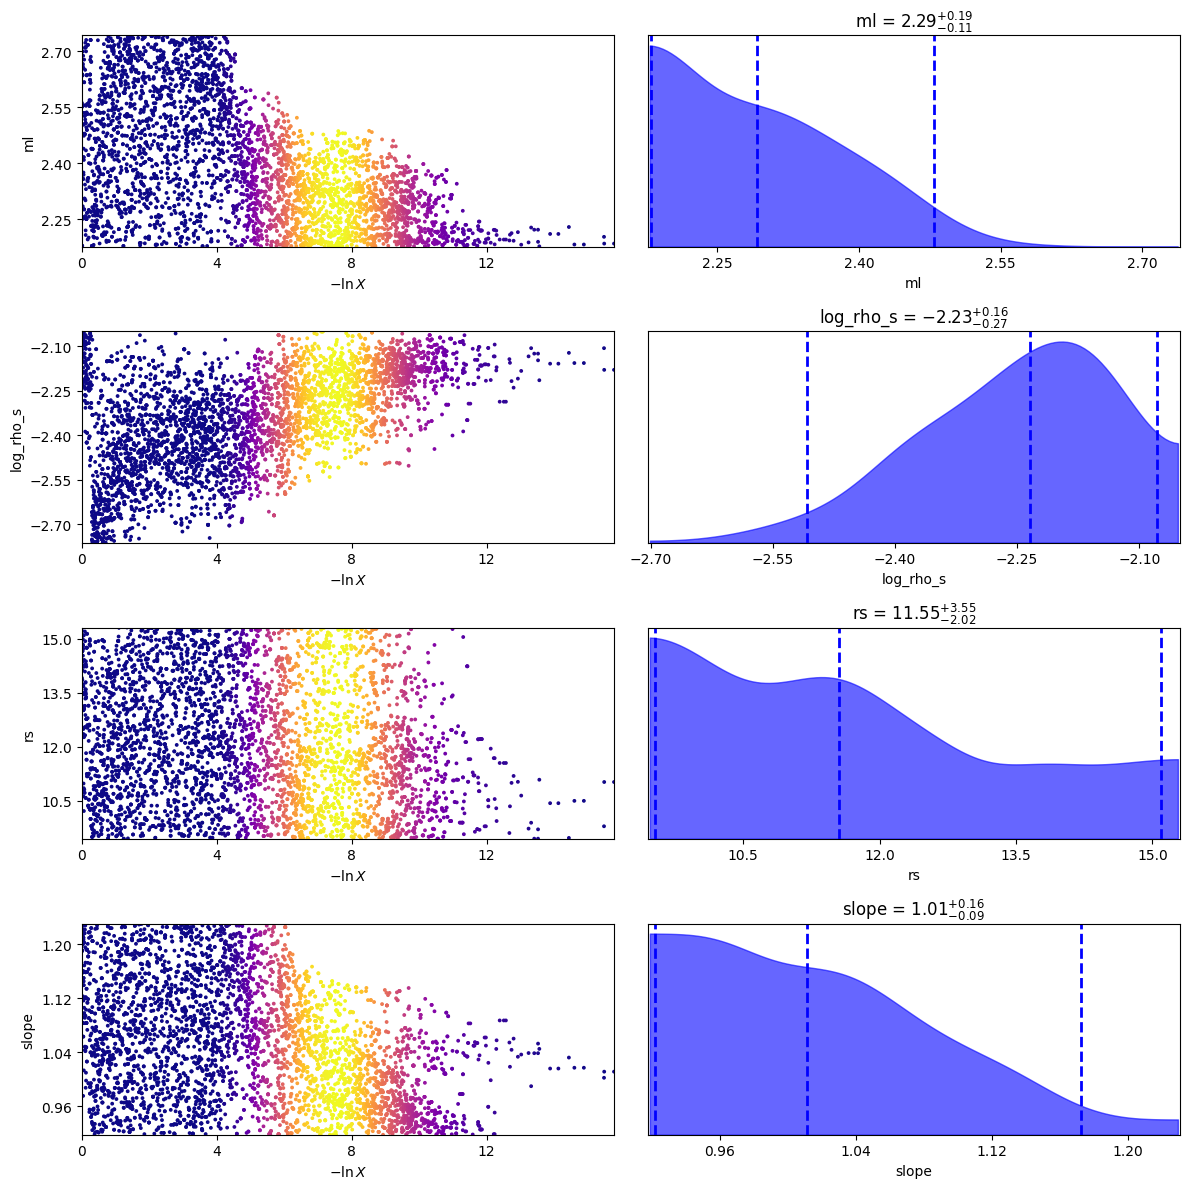

In [6]:
fig, axes = dyplot.traceplot(results=results_sim, smooth=0.08,
                             show_titles=True,
                             labels=labels,
                             )
fig.tight_layout()


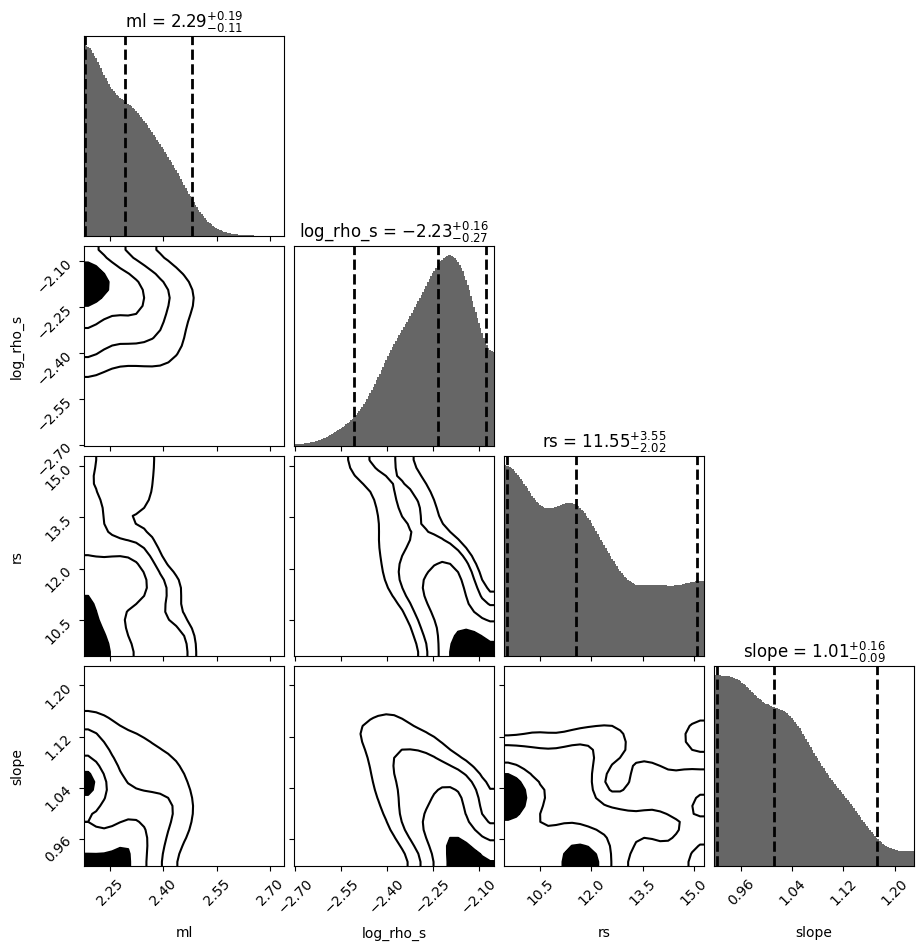

In [7]:
# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results_sim, smooth=0.08,
                                show_titles=True,labels=labels,
                                
                               )

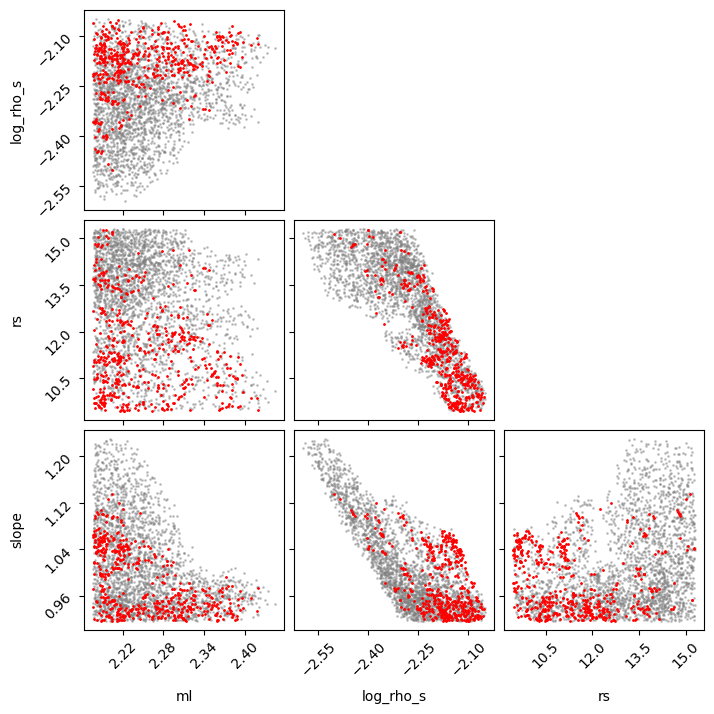

In [8]:
a = dyplot.cornerbound(sampler.results, it=sampler.it, labels=labels,
                       prior_transform=prior_transform,
                       show_live=True, live_color="red",)

In [9]:
import autolens as al

In [10]:
ph5.parsSource

{'pixels': 137.58313074189212,
 'weight_floor': 0.8707998591182,
 'weight_power': 18.31644816209561,
 'inner_coefficient': 0.5221179341560586,
 'outer_coefficient': 21.09366860008702,
 'signal_scale': 0.04301960192119747}

In [11]:
adp_pix = ph5.source_pix(pixels=int(ph5.parsSource["pixels"]),
                            weight_floor=ph5.parsSource["weight_floor"],
                            weight_power=ph5.parsSource["weight_power"]
                            )

adp_reg = ph5.source_reg(inner_coefficient=ph5.parsSource["inner_coefficient"],
                            outer_coefficient=ph5.parsSource["outer_coefficient"],
                            signal_scale=ph5.parsSource["signal_scale"]
                            )

source_model = al.Galaxy(redshift=CM.Lens_model.z_s,
                            pixelization=adp_pix, regularization=adp_reg,
                            hyper_model_image=ph5.hyper_image_2d,
                            hyper_galaxy_image=ph5.hyper_image_2d,
                            )

CM.source_galaxy(source_model=source_model)  #Setting the source galaxy model


In [12]:
CM.quiet = False
CM.Updt_Model(parsRes)



 --------------------------------- 

ParsDic: {'ml': 2.3006741464265406, 'log_rho_s': -2.254290803371432, 'rs': 11.77996955038705, 'qDM': 1.0, 'slope': 1.0195477067388459, 'gamma': 1.0}

 --------------------------------- 

Parameters Updated!


Including the following Analytical DM profile:
#------------------------------------#
EllNFWGeneralized
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
kappa_s: 0.06567675331715103
scale_radius: 11.77996955038705
inner_slope: 1.0195477067388459


Lens Galaxy Configuration:
Log Likelihood_with_regularization: 5945.644737697216
Log Likelihood: 5955.953016325895
Log Normalization -14428.520733928935
Log Evidence: 5528.697699706903
Figure of merit: 5528.697699706903
#------------------------------------#
Redshift: 0.1972841823760099
Mass Profiles:
MGE
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
gamma: 1.0
cosmology: FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
analytic_profile: EllNFWGeneralized
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
kappa_s: 0.06567675331715103
scale_radius: 11.77996955038705
inner_slope: 1.0195477067388459
z_l: 0.1972841823760099
z_s: 0.8049
critical_density: 3364598852859003.

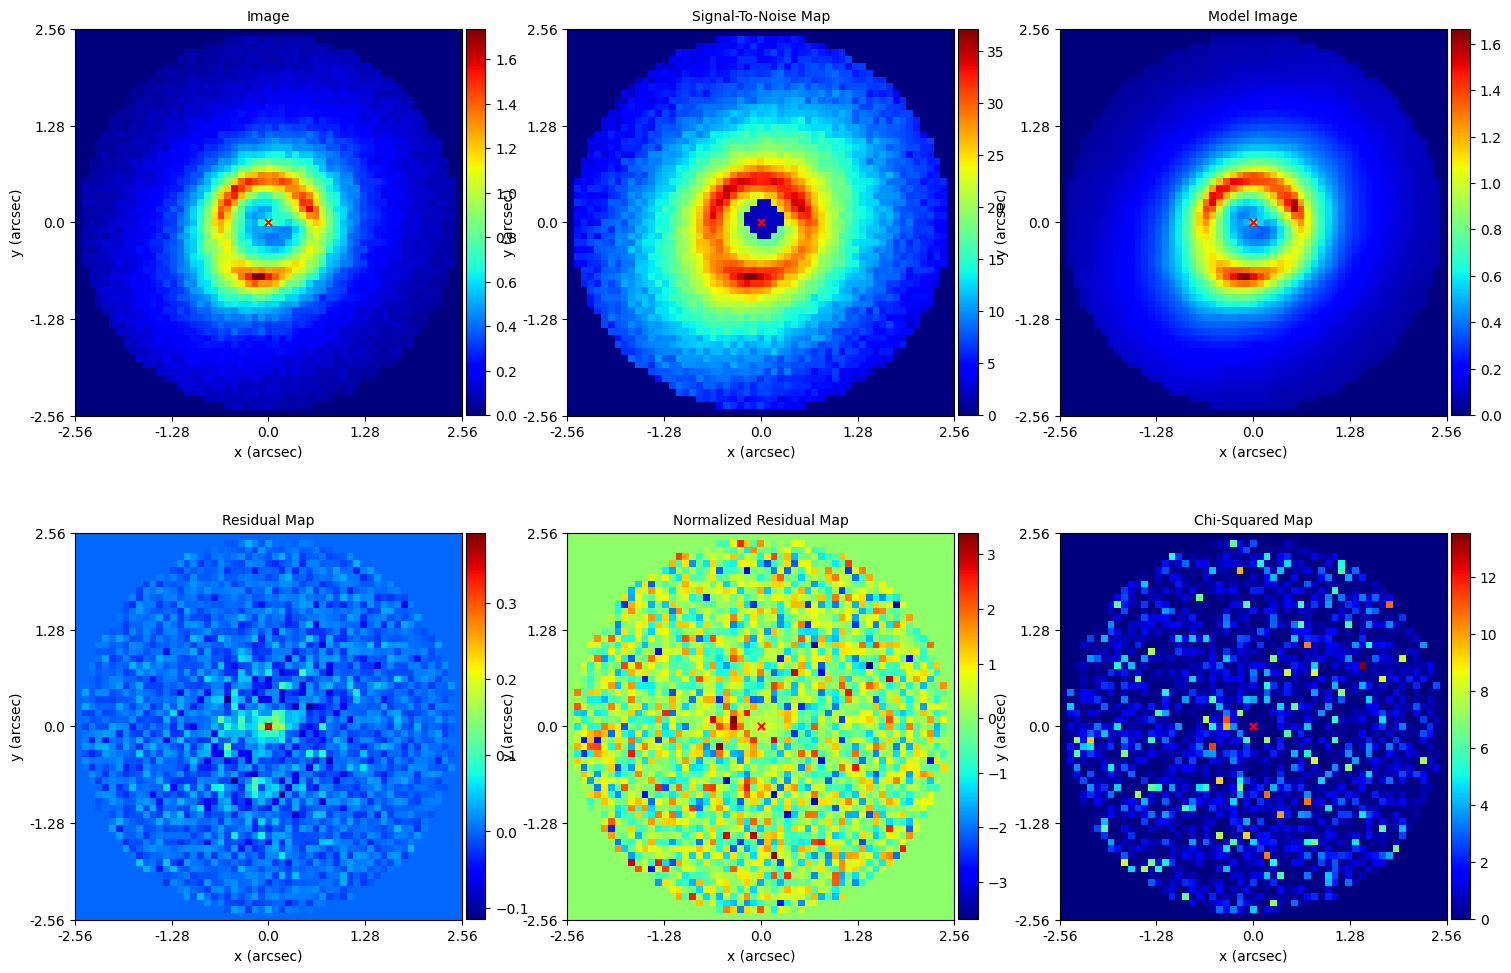

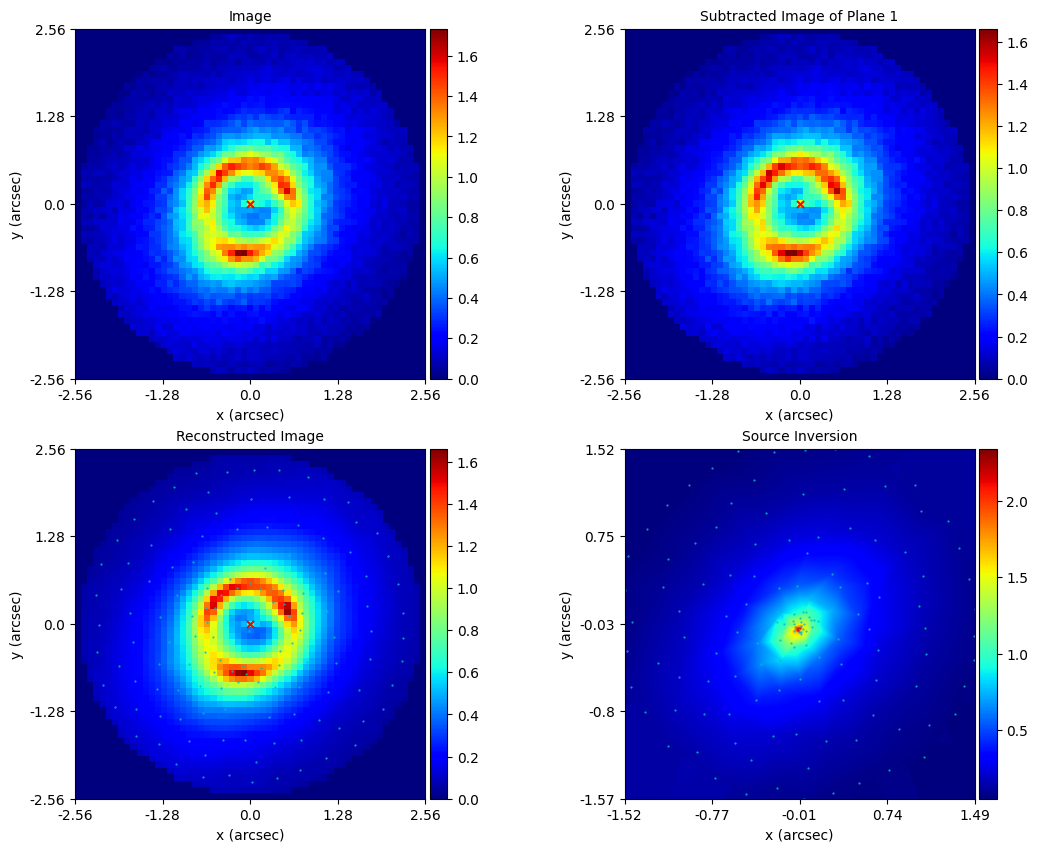

5528.697699706903

In [13]:
CM.run_current(quiet=False)

In [14]:
einstein_radius = CM.Fit.tracer.einstein_radius_from(CM.Fit.imaging.grid)
einstein_radius

Grid2DIrregular(0.63753157)

In [ ]:
from astropy.cos

In [19]:
CM.Lens_model.surf_lum

array([6149.64510161, 4404.63218762, 1167.97487304,  206.56749586,
         37.48278395,   14.30992075])

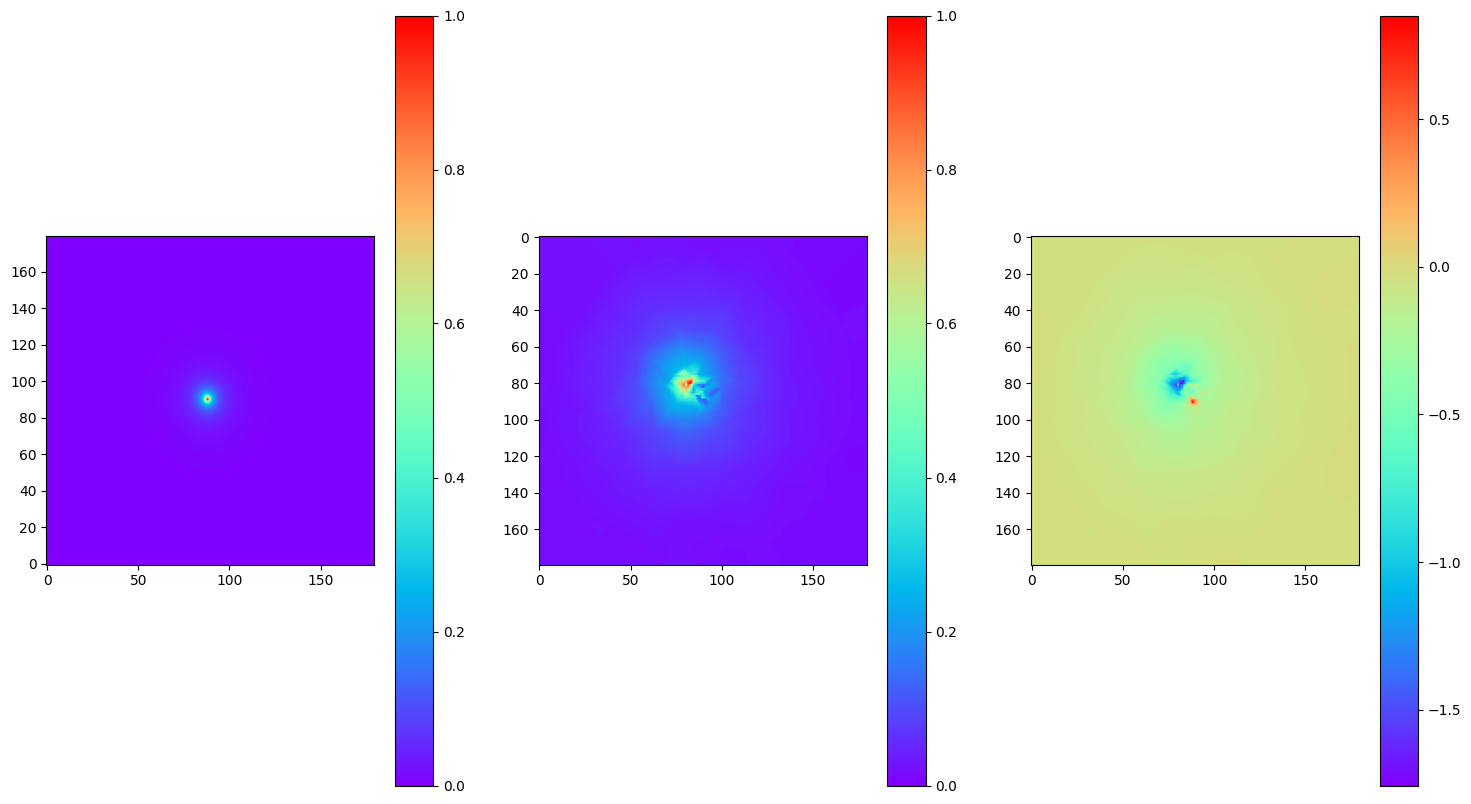

In [14]:
import autolens.plot as aplt
from astropy.io import fits
import matplotlib.pyplot as plt
# Load the original source)
path = "/home/carlos/Documents/GitHub/my_illustris/TNG50-1-snap84-subhalo313415//"
source = fits.open(path+"/lens/source_galaxy.fits")[0].data

interpolated_reconstruction_list = CM.Fit.inversion.interpolated_reconstruction_list_from(
    shape_native=(source.shape[1], source.shape[0]),
)

model = interpolated_reconstruction_list[0].native

plt.figure(figsize=(18,10))

plt.subplot(131)
plt.imshow(source/np.max(source), 
           origin="lower", cmap="rainbow", vmin=0.,)
plt.colorbar()

plt.subplot(132)
plt.imshow(model/np.max(model),
            cmap="rainbow", vmin=0., )
plt.colorbar()

plt.subplot(133)
plt.imshow( (source - model), 
            cmap="rainbow")
plt.colorbar()

-----

In [15]:
from jampy.mge_radial_mass import mge_radial_mass
from jampy.mge_half_light_isophote import mge_half_light_isophote
from astropy import units as u


    # Get the effective radius in arcsec, and other quantities
    # See mge_half_light_isophote documentation for more details
reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(CM.Lens_model.surf_lum,
                                                         CM.Lens_model.sigma_lum,
                                                         CM.Lens_model.qobs_lum,
                                                         CM.Jampy_model.distance)

In [16]:
#  Model
rad     = 2.5* reff    # 2.5 Reff in arcsec
print(rad)
rad_kpc = ( (rad*u.arcsec * CM.Jampy_model.distance*u.Mpc ).to(
                    u.kpc,u.dimensionless_angles()) ).value # 2.5Reff in kpc


    # Get the radial mass of stars and DM within rad
stellar_mass = mge_radial_mass(CM.Lens_model.surf_lum * CM.ml_model, 
                               CM.Lens_model.sigma_lum, CM.Lens_model.qobs_lum,
                               CM.Jampy_model.inc, rad, CM.Jampy_model.distance)

dm_mass = mge_radial_mass(CM.Jampy_model.surf_dm, 
                               CM.Jampy_model.sigma_dm, CM.Jampy_model.qobs_dm,
                               CM.Jampy_model.inc, rad, CM.Jampy_model.distance)
bh_mass = CM.Lens_model.mbh  # Model BH mass

    # Total Mass
total_mass = stellar_mass + dm_mass
    # Dark matter fraction
dm_fraction = dm_mass / total_mass

0.8662867097146382


In [18]:
# Data
    # Changes this path to where are your data
    # Load the snapshot data
dm_dataset   = np.load(path+"/dm/coordinates_dark.npy")
star_dataset = np.load(path+"/imgs/coordinates_star.npy")
    
    # Stellar content
rStar = np.sqrt(np.sum(star_dataset[:, 0:3]**2, axis=1)) # radius
i = rStar <= rad_kpc                                     # only particles within 2.5Reff
Mstar = sum(star_dataset[:, 6][i]*1e10)                  # stellar mass within 2.5Reff



    # Dark content
rDM = np.sqrt(np.sum(dm_dataset[:, 0:3]**2, axis=1))
i = rDM <= rad_kpc
Mdm = sum(dm_dataset[:,3][i]*1e10)

Mbh = 10**8.36 # BH mass from TNG catalogue
    # Total snapshot mass within 2.5Reff
Tmass = Mstar + Mdm
    # DM fraction in the snapshot within 2.5Reff
DM_f = Mdm/Tmass

In [19]:


print("Model stellar Mass: {:.2e} Msun".format( float(stellar_mass) ))
print("Data  stellar Mass: {:.2e} Msun".format( float(Mstar) ))
f = (stellar_mass - Mstar)/Mstar
print("(Model - Data)/Data: {:.2f}".format( float(f) ))



Model stellar Mass: 1.43e+11 Msun
Data  stellar Mass: 1.08e+11 Msun
(Model - Data)/Data: 0.32


In [20]:


print("Model dm Mass: {:.2e} Msun".format( float(dm_mass) ))
print("Data  dm Mass: {:.2e} Msun".format( float(Mdm) ))
f = (dm_mass - Mdm)/Mdm
print("(Model - Data)/Data: {:.2f}".format( float(f) ))



Model dm Mass: 1.66e+10 Msun
Data  dm Mass: 5.10e+10 Msun
(Model - Data)/Data: -0.67


In [21]:
print("Model total Mass: {:.2e} Msun".format( float(total_mass) ))
print("Data  total Mass: {:.2e} Msun".format( float(Tmass) ))
f = (total_mass - Tmass)/Tmass
print("(Model - Data)/Data: {:.2f}".format( float(f) ))

Model total Mass: 1.59e+11 Msun
Data  total Mass: 1.59e+11 Msun
(Model - Data)/Data: 0.00


In [22]:
print("Model DM fraction: {:.2f}".format( float(dm_fraction) ))
print("Data  DM fraction: {:.2f}".format( float(DM_f) ))
f = (dm_fraction - DM_f)/DM_f
print("(Model - Data)/Data: {:.2f}".format( float(f) ))

Model DM fraction: 0.10
Data  DM fraction: 0.32
(Model - Data)/Data: -0.67


In [23]:
from jampy.mge_radial_density import mge_radial_density

In [24]:
# Radial Density profile
radii    = np.arange(0.1, 10*reff, 0.01)  # Radii in arcsec
pc       = CM.Jampy_model.distance*np.pi/0.648  # Constant factor to convert arcsec --> pc
radii_pc = radii*pc                   #Radii in pc

dstar = mge_radial_density(CM.Lens_model.surf_lum * CM.ml_model, 
                               CM.Lens_model.sigma_lum, CM.Lens_model.qobs_lum,
                               CM.Jampy_model.inc, radii, CM.Jampy_model.distance)

ddm = mge_radial_density(CM.Jampy_model.surf_dm, 
                               CM.Jampy_model.sigma_dm, CM.Jampy_model.qobs_dm,
                               CM.Jampy_model.inc, radii, CM.Jampy_model.distance)

# Load DM density profile
from astropy.io import fits
dm_hdu = fits.open(path+"/dm/density_fit.fits")
true_density = dm_hdu[1].data["density"]
true_radii = dm_hdu[1].data["radius"]
dm_fit = dm_hdu[1].data["bestfit"]

i = true_radii < radii_pc.max()

true_density = true_density[i]
true_radii   = true_radii[i]
dm_fit = dm_fit[i]

# Stars density profile
star_hdu = fits.open(path+"/imgs/stellar_density.fits")
rho_stars = star_hdu[1].data["density"]
r_star = star_hdu[1].data["radius"]

i = r_star < radii_pc.max()

rho_stars = rho_stars[i]
r_star   = r_star[i]

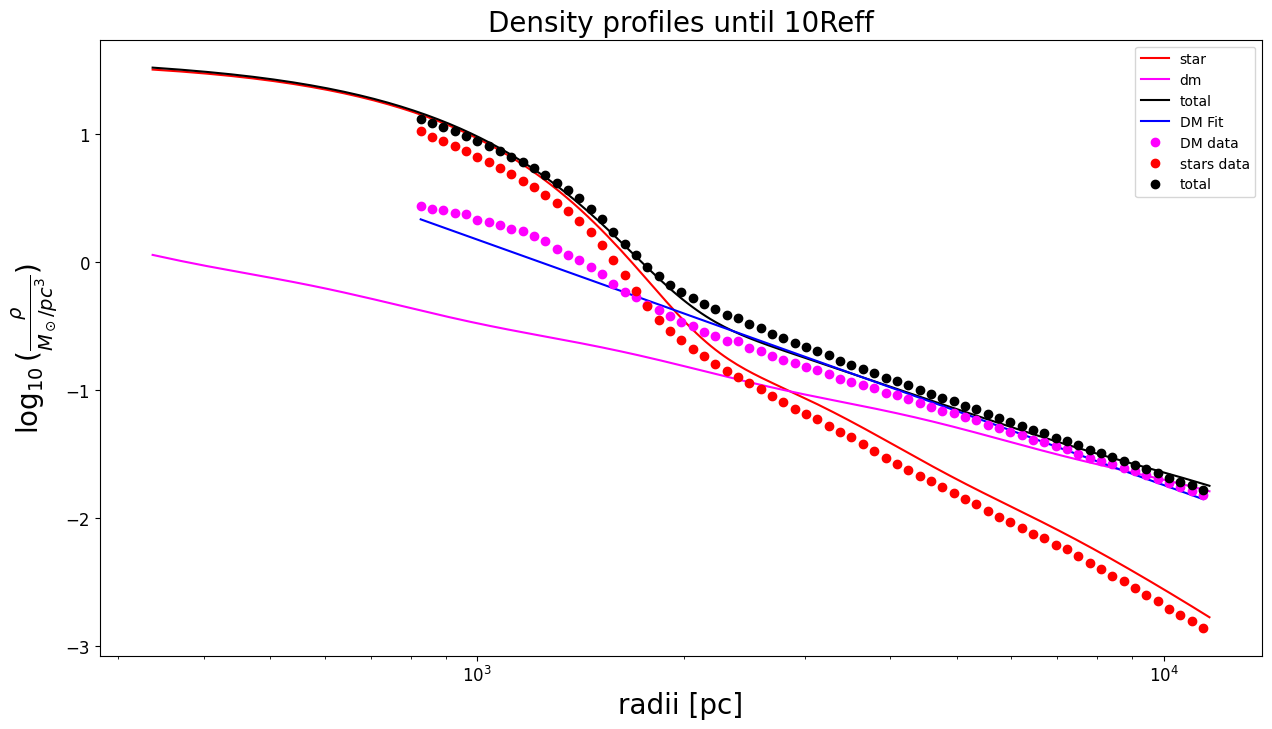

In [25]:
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize']= 12
plt.rcParams['ytick.labelsize']= 12


plt.figure(figsize=(15,8))

plt.plot(radii_pc, np.log10(dstar), label="star", color="red")
plt.plot(radii_pc, np.log10(ddm), label="dm", color="magenta")
plt.plot(radii_pc, np.log10(ddm+dstar), label="total", color="black")
plt.plot(true_radii, np.log10(dm_fit), label="DM Fit", color="blue", markersize=12)
#plt.plot(radii_pc, np.log10(a), label="MGE", color="black")

plt.plot(true_radii, np.log10(true_density),  ".", label="DM data", color="magenta", markersize=12)
plt.plot(r_star, np.log10(rho_stars),  ".", label="stars data", color="red", markersize=12)
plt.plot(r_star, np.log10(rho_stars+true_density),  ".", label="total", color="black", markersize=12)




plt.title("Density profiles until 10Reff", size=20)
plt.xlabel("radii [pc]", size=20)
plt.ylabel("$\log_{10}(\\frac{\\rho}{M_\odot/pc^3})$", size=20)
plt.legend()
plt.xscale("log")

---